# Contents

* [Read data](#read)
* [Calculate k-values](#kvalues)
* [Preprocess trajectories](#preprocess)
* [Exclude trials/participants](#exclude)
* [Save preprocessed data](#save)

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import random
import helper_functions
import pandas as pd
import os
import seaborn as sns
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# data_path = '../data/'
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
figure_path = 'C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures'

figure_format = '.png'

helper = helper_functions.HelperFunctions()

# Read data <a class="anchor" id="read"></a>

When reading the data, we set the index to self.index to be able to transfer the results of processing the dynamics dataframe to the choices dataframe. This is also convenient for data wrangling (e.g., `dynamics.loc[subj_id, task, trial_no])`. However, we also keep index as columns (drop=False) for more convenient pre-processing and plotting. Having the same data as a column and as an index is not very pythonic, but is justified here IMO. Because of this, pandas throws tons of warnings here and there, but those can be ignored so far.     

In [2]:
def read_data(path='data', index=['subj_id', 'task', 'trial_no']):
    file_path = os.path.join(path, '%s.txt')

    choices = pd.read_csv(file_path % 'choices', sep='\t')
    choices.set_index(index, inplace=True, drop=False)
    dynamics = pd.read_csv(file_path % 'dynamics', sep='\t')
    dynamics.set_index(index, inplace=True, drop=False)

    choices = choices.rename(columns={'option_chosen': 'choice'})
    choices = choices.rename(columns={'order': 'sequence'})
    dynamics = dynamics.rename(columns={'timestamp': 't'})
    
    is_first_task = (((choices.task=='mouse') & (choices.sequence=='mw')) | 
                 ((choices.task=='walking') & (choices.sequence=='wm')))

    choices.loc[is_first_task, 'session'] = 'first'
    choices.loc[~is_first_task, 'session'] = 'second'
    
    choices['choice'] = choices['choice'].str.upper()
    
    choices['is_staircase'] = choices['is_staircase'].astype('bool')
    choices['ss_chosen'] = ((choices['choice']) == 'SS')
    choices['chosen_amount'] = (choices['ss_amount'] * choices['ss_chosen'] +
                                choices['ll_amount'] * (~choices['ss_chosen']))
    choices['chosen_delay'] = (choices['ss_delay'] * choices['ss_chosen'] +
                               choices['ll_delay'] * (~choices['ss_chosen']))
    choices['amount_ratio'] = choices['ss_amount'] / choices['ll_amount']

    choices['amount_diff'] = choices['ll_amount'] - choices['ss_amount']
    choices['amount_increase'] = (choices['ll_amount'] - choices['ss_amount']) / choices['ss_amount']
    choices['LL_advantage'] = choices['amount_diff'] / choices['ll_delay']
    choices['lambda'] = np.log(choices['LL_advantage'])
    
    choices['lambda_q'] = choices.groupby(['task', 'choice'])['lambda'].transform(
                     lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))
    
    choices = choices.drop(['response', 'start_time'], axis=1)

    # express mouse coordinates in pixels (the screen size was 1920 x 1080)
    dynamics.loc[dynamics.task=='mouse', 'x'] *= 860
    dynamics.loc[dynamics.task=='mouse', 'y'] *= 540

    return choices, dynamics

def get_random_traj(choices, dynamics):
    return dynamics.loc[choices.sample().index]

In [3]:
choices, dynamics = read_data(data_path)

print("Number of particpants: %i" % (len(choices.index.get_level_values('subj_id').unique())))

Number of particpants: 74


# Calculate k-values <a class="anchor" id="kvalues"></a>

Calculate k-values and excluding participants based on extreme discounting behavior along the way

In [4]:
k_values, ip_values = helper.get_k_values(choices, log=False)
extreme_k = k_values.loc[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                         ((k_values.mouse<0.02)&(k_values.walking<0.02)), 'subj_id']

print("Participants excluded: %i" % (len(extreme_k)))
print(extreme_k.values)

choices = choices[~choices.index.get_level_values('subj_id').isin(extreme_k)]
dynamics = dynamics[~dynamics.index.get_level_values('subj_id').isin(extreme_k)]
k_values = k_values[~k_values.subj_id.isin(extreme_k)]
ip_values = ip_values[~ip_values.subj_id.isin(extreme_k)]

Participants excluded: 14
[1095 1122 1282 1971 3846 4232 4550 4679 5389 5397 7095 7958 8767 9790]


For exploratory analysis, we also calculate distance to indifference point for each trial (see Dshemuchadze et al (2013))

In [5]:
def get_distance_to_ip(choice, ip_values):
    indiff_curve = ip_values.loc[(ip_values.subj_id == choice.subj_id) & 
                                 (ip_values.task == choice.task)]
    indiff_point = np.interp(choice.ll_delay, indiff_curve.ll_delay, indiff_curve.indiff_point)
    # distance is negative if amount_ratio is above indifference curve
    # this is done to be able to interpret distance as a relative advantage of the LL option
    # If amount_ratio is lower than indifference point, this means that choosing 
    distance = indiff_point - choice.amount_ratio
    return distance  

choices['Delta'] = choices.transform(lambda row: get_distance_to_ip(row, ip_values), axis=1)
choices['Delta_q'] = choices.groupby(['choice'])['Delta'].transform(
                     lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))

# Preprocess decision dynamics <a class="anchor" id="preprocess"></a>

### Get around missing data and noise in walking trajectories

Checking missing data in walking trajectories

In [6]:
print("Data loss rate in walking trials: %f" % 
      (len(dynamics[(dynamics.task=='walking')&(dynamics.x.isna())])/len(dynamics[dynamics.task=='walking'])))

Data loss rate in walking trials: 0.025384


In [7]:
def get_data_loss_rate(trajectory):
    return len(trajectory[(trajectory.x.isna())])/len(trajectory)
data_loss_rate = dynamics.groupby(dynamics.index.names).apply(get_data_loss_rate)

How many trials are there with at least 10% data loss?

In [8]:
print(data_loss_rate[data_loss_rate>0.1])

subj_id  task     trial_no
1474     walking  42          0.474265
3720     walking  27          0.201022
5778     walking  27          0.168798
5781     walking  10          0.849146
5985     walking  17          0.669086
                  34          0.264664
6920     walking  24          0.179353
7921     walking  2           0.105469
                  27          0.425210
9970     walking  1           0.500000
dtype: float64


This is what they look like

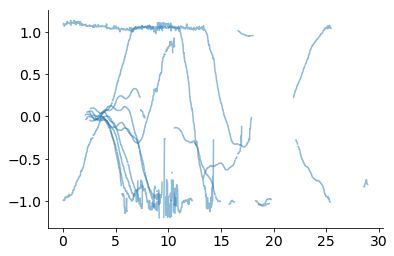

In [9]:
fig, ax = plt.subplots(1)
helper.plot_trajectories(dynamics[data_loss_rate>0.1], kind='time', ax=ax)

Let's exclude these trajectories and interpolate missing data in all the others

In [10]:
print('Trials excluded: %i' % (len(data_loss_rate[data_loss_rate>=0.1])))

choices = choices[data_loss_rate<0.1]
dynamics = dynamics[data_loss_rate<0.1]

Trials excluded: 10


In [11]:
dynamics.loc[choices.task=='walking', ['x', 'y']] = (dynamics.loc[choices.task=='walking', ['x', 'y']].
                                                     groupby(choices.index.names).transform(pd.DataFrame.interpolate))

# delete remaining nans (which are still left at the start of some trials even after interpolate())
dynamics = dynamics.dropna(subset=['x', 'y'])

Smooth out noise in the walking data using Savitzky-Golay filter

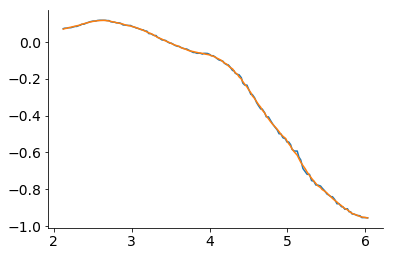

In [12]:
traj = get_random_traj(choices[choices.task=='walking'], dynamics[dynamics.task=='walking'])
plt.plot(traj.t, traj.x)
plt.plot(traj.t, savgol_filter(traj.x, window_length=21, polyorder=2))

In [13]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
dynamics.loc[choices.task=='walking', ['x', 'y']] = (dynamics.loc[choices.task=='walking', ['x', 'y']].
                                                     groupby(choices.index.names).transform(apply_filter))

### Calculate derivatives

In [14]:
dynamics = helper.append_derivatives(dynamics)

### Discard trials with problematic Kinect data

In [15]:
v_max = dynamics.groupby(choices.index.names).apply(lambda traj: abs(traj.vy).max())

We might want to exclude the trials with extreme max velocity. Such 'jumping' can appear, for instance, when
* After the end of the previous trial, even after a subject walked back to the starting point and entered the camera deadzone, Kinect sometimes remembered the last recorded position of a subject. Not sure why, but in a fraction of trials this position was carried over to the next trial even after I manually re-set it. For this reason, in these trials the stimuli were shown to the subjects before they even started walking out of the deadzone.
* Sometimes Kinect lost track of a subject when they walked over one of the response location. In these (rare) cases the subjects were asked to make a couple of steps back until Kinect could detect them again.

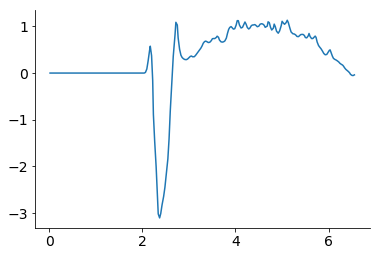

In [16]:
traj = dynamics.loc[choices[choices.task=='walking'].loc[(v_max>1.5)].sample().index]
plt.plot(traj.t, traj.vy)

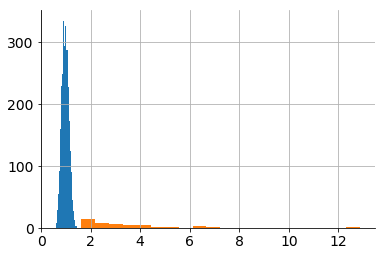

In [17]:
v_max_w = v_max[v_max.index.get_level_values('task')=='walking']
v_max_w[v_max_w<1.5].hist(bins=20)
v_max_w[v_max_w>1.5].hist(bins=20)

In [18]:
print('Trials excluded: %i' % (len(choices[choices.task=='walking'].loc[v_max>=1.5])))

choices = choices[(choices.task=='mouse') | ((choices.task=='walking') & (v_max<1.5))]
dynamics = dynamics[(dynamics.task=='mouse') | ((dynamics.task=='walking') & (v_max<1.5))]

Trials excluded: 44


We also exclude trials with non-positive initial velocity. These trials result from another possible glitch in the data collection scripts: the recording started despite the subject position (which was manually reset to (0,0) in the beginning of a trial) was within the deadzone.

In [19]:
v_first = dynamics.groupby(choices.index.names).vy.first()

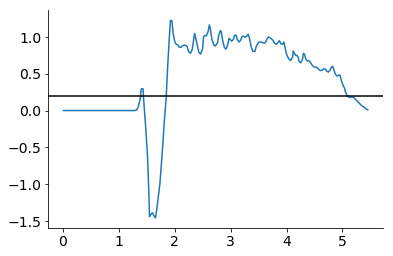

In [20]:
traj = dynamics.loc[choices.loc[(choices.task=='walking') & (v_first<=0.01)].sample().index]
plt.plot(traj.t, traj.vy)
plt.axhline(0.2, color='k')

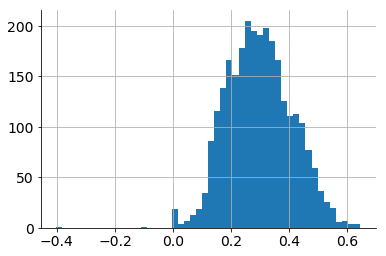

In [21]:
v_first[v_first.index.get_level_values('task')=='walking'].hist(bins=50)

In [22]:
print('Trials excluded: %i' % (len(choices[(choices.task=='walking') & (v_first<=0.01)])))

choices = choices[(choices.task=='mouse') | ((choices.task=='walking') & (v_first>0.01))]
dynamics = dynamics[(dynamics.task=='mouse') | ((dynamics.task=='walking') & (v_first>0.01))]

Trials excluded: 21


### Change coordinate frame

Shift every trajectory so that on average they all start at $t=0$ around (0,0)

In [23]:
def transform_xy(dynamics):
    starting_points = dynamics.groupby(by=['subj_id', 'trial_no']).first()
    dynamics.x = dynamics.x - starting_points.mean(axis=0).x
    dynamics.y = dynamics.y - starting_points.mean(axis=0).y

    return dynamics

In [24]:
dynamics.loc[choices.task=='mouse'] = transform_xy(dynamics.loc[choices.task=='mouse'])
dynamics.loc[choices.task=='walking'] = transform_xy(dynamics.loc[choices.task=='walking'])

dynamics.loc[:, 't'] = dynamics.t.groupby(by=choices.index.names).transform(lambda t: (t-t.min()))

Flip the trajectories such that the SS option is always on the left and LL option is on the right

In [25]:
dynamics.loc[~choices.is_ss_on_left, ['x']] *= -1

### Resample trajectories

If needed, resample trajectories so that each of them has exactly 301 data points (this is needed for plotting average trajectories and exploratory analysis)

In [26]:
def resample_trajectory(trajectory, n_steps=300):
    t_regular = np.linspace(trajectory.t.min(), trajectory.t.max(), n_steps + 1)
    x_interp = np.interp(t_regular, trajectory.t.values, trajectory.x.values)
    y_interp = np.interp(t_regular, trajectory.t.values, trajectory.y.values)
    traj_interp = pd.DataFrame([t_regular, x_interp, y_interp]).transpose()
    traj_interp.columns = ['t', 'x', 'y']

    return traj_interp

def apply_trajectory_resampling(choices, dynamics):
    dynamics = dynamics.groupby(by=['subj_id', 'task', 'trial_no']).apply(resample_trajectory)
    dynamics = dynamics.reset_index(drop=False)
    dynamics = dynamics.drop(['level_3'], axis=1)
    dynamics = dynamics.set_index(choices.index.names, drop=False)

    return dynamics

In [27]:
dynamics = apply_trajectory_resampling(choices, dynamics)

### Get trajectory measures

Calculate derivatives again after resampling and flipping (double work can be avoided but we keep it as is for clarity)

In [28]:
dynamics = helper.append_derivatives(dynamics)

Calculate trajectory measures (max-d, midline-d, RT)

In [29]:
def get_maxd(trajectory):
    alpha = np.arctan((trajectory.y.iloc[-1] - trajectory.y.iloc[0]) / \
                      (trajectory.x.iloc[-1] - trajectory.x.iloc[0]))
    d = (trajectory.x.values - trajectory.x.values[0]) * np.sin(-alpha) + \
        (trajectory.y.values - trajectory.y.values[0]) * np.cos(-alpha)

    if np.isnan(d).all():
        return pd.Series({'max_d': np.nan, 'idx_max_d': np.nan})
    elif abs(np.nanmin(d)) > abs(np.nanmax(d)):
        return pd.Series({'max_d': np.nanmin(d), 'idx_max_d': np.nanargmin(d)})
    else:
        return pd.Series({'max_d': np.nanmax(d), 'idx_max_d': np.nanargmax(d)})

def get_midline_d(traj):
    x = traj.x.values
    is_final_point_positive = (x[-1]>0)
        
    midline_d = x.min() if is_final_point_positive else x.max()

    idx_midline_d = (x == midline_d).nonzero()[0][-1]
    midline_d_y = traj.y.values[idx_midline_d]
    return pd.Series({'midline_d': abs(midline_d), 
                      'idx_midline_d': idx_midline_d,
                      'midline_d_y': midline_d_y})

def get_measures(choices, dynamics):
    choices = choices.join(dynamics.groupby(by=choices.index.names).apply(get_maxd), on=choices.index.names)
    choices = choices.join(dynamics.groupby(by=choices.index.names).apply(get_midline_d), on=choices.index.names)
    choices['RT'] = dynamics.groupby(by=choices.index.names).apply(lambda traj: traj.t.max() - traj.t.min())
    choices['is_com'] = False
    choices.loc[(choices.task =='mouse'), ['is_com']] = ((choices.task =='mouse') & 
                                                         (choices.midline_d > 150) & 
                                                         (choices.max_d > 300))
    choices.loc[(choices.task=='walking'), ['is_com']] = ((choices.task=='walking') & 
                                                          (choices.midline_d > 0.2) & 
                                                          (choices.max_d > 0.7))
    return choices

In [30]:
choices = get_measures(choices,dynamics)

# Exclude trials/participants <a class="anchor" id="exclude"></a>

### Exclude based on RT and max-d

The ranges of allowed response times specified in the preregistration were 2 to 7s in the walking task and 1 to 5s in the mouse task. These values were based on the distributions observed in pilot data, however, in the full-scale experiment the variability was higher so we need to adjust the exclusion thresholds to keep as much valid data as possible.

<b>Walking task</b>

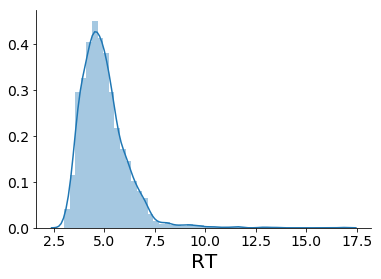

In [31]:
ax = sns.distplot(choices[choices.task=='walking'].RT)
# ax.set_xlim(2,15)
# ax.set_yscale('log')

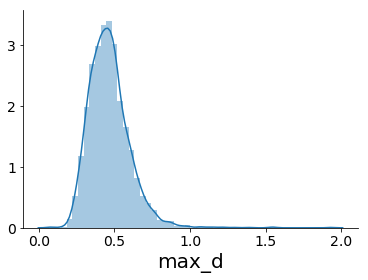

In [32]:
ax = sns.distplot(choices[choices.task=='walking'].max_d)

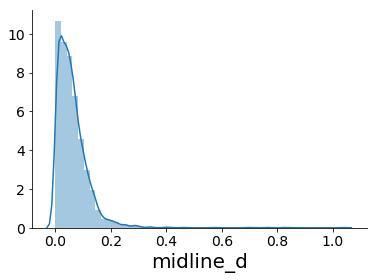

In [33]:
ax = sns.distplot(choices[(choices.task=='walking')].midline_d)

Based on these distributions, we will exclude the walking trials with `RT>8` and `max_d<0`. One might be tempted to exclude `max_d>1`, but these trials don't seem to be outliers

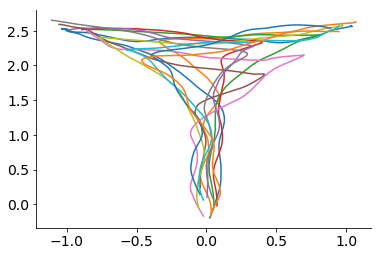

In [34]:
trials = choices[(choices.task=='walking')&(choices.max_d>1)].index
for traj in trials:
    plt.plot(dynamics.loc[traj].x, dynamics.loc[traj].y)

In [35]:
exclude_walking_outliers = ((choices.task=='walking') & ((choices.RT > 8) | (choices.max_d < 0)))

print('Trials excluded: %i' % (len(choices[exclude_walking_outliers])))

choices = choices[~exclude_walking_outliers]
dynamics = dynamics[~exclude_walking_outliers]

Trials excluded: 49


<b>Mouse task</b>

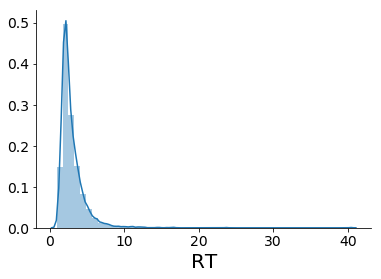

In [36]:
ax = sns.distplot(choices[choices.task=='mouse'].RT)
# ax.set_xlim(0,15);

Max-d distribution

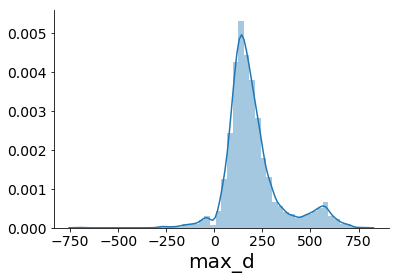

In [37]:
ax = sns.distplot(choices[choices.task=='mouse'].max_d)

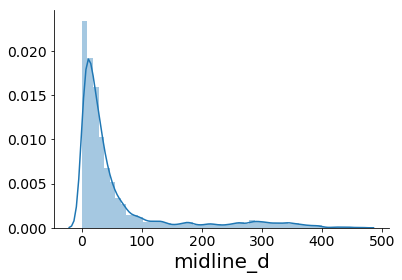

In [38]:
ax = sns.distplot(choices[(choices.task=='mouse')].midline_d)

Based on these distributions, we will exclude the mouse trials with `RT>8s` and `max_d<-300px`. In addition, we exclude weird trials where `max-d` is small but `midline-d` is large, e.g.

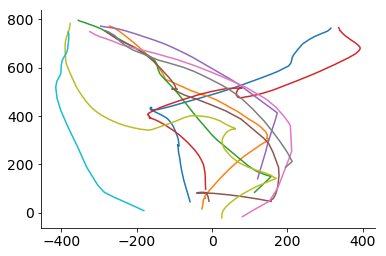

In [39]:
trials = choices[(choices.task=='mouse')&((choices.max_d<300)&(choices.midline_d>150))]
for traj in trials.sample(min(10, len(trials))).index:
    plt.plot(dynamics.loc[traj].x, dynamics.loc[traj].y, label='%.2f' % (choices.loc[traj].midline_d))

In [40]:
exclude_mouse_outliers = ((choices.task=='mouse') & 
                     (((choices.RT > 8) | (choices.max_d < -300) | 
                       (choices.max_d<300)&(choices.midline_d>150))))

print('Trials excluded: %i' % (len(choices[exclude_mouse_outliers])))

choices = choices[~exclude_mouse_outliers]
dynamics = dynamics[~exclude_mouse_outliers]

Trials excluded: 80


### Exclude slowdowns in the walking task

In the pre-registration we specified that we will exclude walking trials in which subjects slow down below certain speed in the middle of the trial. The speed threshold of `0.2m/s` was determined based on the pilot data.

In [41]:
dynamics['v'] = np.sqrt(np.power(dynamics['vx'], 2) + np.power(dynamics['vy'], 2))

In [42]:
slowdown_trials = (dynamics.groupby(dynamics.index.names).apply(lambda traj: ((abs(traj.v)<0.2) & (traj.y<2)).any()))
print(len(choices[(slowdown_trials) & (choices.task=='walking')]))
print(len(choices[(slowdown_trials) & (choices.task=='walking')])/len(choices[(choices.task=='walking')]))

637
0.2362759643916914


In about 23% of all walking trials subjects slowed down to 0.2m/s at least during one time step. As this threshold seems to be too strict to be applied as initially intended, we relax it by only discarding trials with total slowdown time more than 1 second

In [43]:
def get_slowdown_time(traj):
    v_threshold = 0.2 # in m/s
    time_step = (traj.t.max() - traj.t.min())/len(traj)
    return ((abs(traj.v)<0.2) & (traj.y<2)).sum()*time_step

t_slowdown = dynamics.groupby(dynamics.index.names).apply(get_slowdown_time)

In [44]:
exclude_slow = (t_slowdown.index.get_level_values('task')=='walking') & (t_slowdown>1)

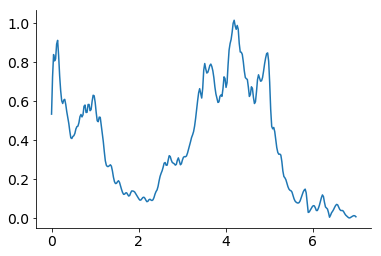

In [45]:
traj = get_random_traj(choices[exclude_slow], dynamics)
plt.plot(traj.t, traj.v)

In [46]:
print('Trials excluded: %i' % len(choices[exclude_slow]))

choices = choices[~exclude_slow]
dynamics = dynamics[~exclude_slow]

Trials excluded: 25


### Excluding subjects with few trials after other exclusions

If in some task a subject had more than 20% trials discarded ($0.8\times47 \approx 38$ trials left), we exclude that subject

In [47]:
n_trials = choices.groupby(['subj_id', 'task']).size()

In [48]:
exclude_subj = n_trials[n_trials<38].reset_index().subj_id.unique()
print(exclude_subj)

[1578 2157 2311 6607 7732 9714]


In [49]:
print('Subjects excluded: %i' % len(exclude_subj))

choices = choices[~choices.subj_id.isin(exclude_subj)]
dynamics = dynamics[~dynamics.subj_id.isin(exclude_subj)]
k_values = k_values[~k_values.subj_id.isin(exclude_subj)]

Subjects excluded: 6


# Save preprocessed data <a class="anchor" id="save"></a>

Save $k$-values for Analysis 2

In [50]:
def save_k_values(k_values, choices, data_path, log=False):
    # saving k-values of all subjects in the "long" format for for Analysis 2
    k_values_long = helper.get_long_k_values(k_values, choices)

    # adding the posterior estimate of the effect of choice on max-d as 
    # a "bias" factor which can moderate the effect of task on k 
    # (subjects with a bias towards SS choice would supposedly be biased less in the mouse task, 
    # as there is an opportunity for a CoM)
    bias = helper.get_ss_bias(data_path)
    k_values_long = k_values_long.join(bias.set_index('subj_id'), on='subj_id')
    
    file_name = 'k_values_%i' % (len(k_values))
    if log:
        file_name += '_log'
    k_values_long.to_csv(os.path.join(data_path, file_name+'.csv'), sep='\t', index=False)

Save preprocessed choices and dynamics for Analysis 1

In [51]:
choices.to_csv(os.path.join(data_path, 'choices_processed.txt'), index=False, float_format='%g')
dynamics.to_csv(os.path.join(data_path, 'dynamics_processed.txt'), index=False, float_format='%g')

In [52]:
k_values, ip = helper.get_k_values(choices, log=False)
save_k_values(k_values, choices, data_path, log=False)

We also calculate and save $k_{\log}$-values for Analysis 2 

In [53]:
k_values, ip = helper.get_k_values(choices, log=True)
save_k_values(k_values, choices, data_path, log=True)